<a href="https://colab.research.google.com/github/nisitha13/Global-Inflation-Forecasting-with-Big-Data/blob/main/Global_Inflation_Forecasting_with_Big_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# -------------------- Full Colab Spark Setup --------------------
# 1️⃣ Install Java
!apt-get update -qq
!apt-get install -y openjdk-11-jdk-headless -qq

# 2️⃣ Download a tested Spark build (archive URL is reliable)
!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz

# 3️⃣ Extract Spark
!tar -xvzf spark-3.3.2-bin-hadoop3.tgz

# 4️⃣ Install Python packages
!pip install -q findspark pyspark pandas matplotlib seaborn wbdata pyarrow

# 5️⃣ Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

# 6️⃣ Initialize findspark and create Spark session
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("GlobalInflationTracker") \
    .getOrCreate()

# 7️⃣ Quick check
print("✅ Spark setup complete! Version:", spark.version)
!ls /content/spark-3.3.2-bin-hadoop3/python/lib/  # should show py4j zip


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
spark-3.3.2-bin-hadoop3/
spark-3.3.2-bin-hadoop3/LICENSE
spark-3.3.2-bin-hadoop3/NOTICE
spark-3.3.2-bin-hadoop3/R/
spark-3.3.2-bin-hadoop3/R/lib/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/DESCRIPTION
spark-3.3.2-bin-hadoop3/R/lib/SparkR/INDEX
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/Rd.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/features.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/hsearch.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/links.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/nsInfo.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/package.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/vignette.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/NAMESPACE
spark-3.3.2-bin-hadoop3/R/lib/SparkR/R/
spark-3.3.2-bin-hadoop3/R/lib/Spa

In [11]:
# Import libraries
import wbdata
import pandas as pd
import datetime

# Define time range
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2023, 12, 31)

# World Bank indicator: Inflation (CPI, annual %)
indicators = {"FP.CPI.TOTL.ZG": "inflation_pct"}

# Fetch data for all countries
df_wb = wbdata.get_dataframe(indicators, country="all", date=(start, end))
df_wb = df_wb.reset_index().rename(columns={"country":"country_name","date":"year"})

# Quick look
print(df_wb.head())

# Save CSV (optional for GitHub sample)
df_wb.to_csv("worldbank_inflation.csv", index=False)

                  country_name  year  inflation_pct
0  Africa Eastern and Southern  2023       7.126975
1  Africa Eastern and Southern  2022      10.773751
2  Africa Eastern and Southern  2021       7.240978
3  Africa Eastern and Southern  2020       5.405162
4  Africa Eastern and Southern  2019       4.644967


In [12]:
# Example: small sample CSV for oil prices
# If you have a Kaggle CSV, upload it and replace the path
import io

oil_csv = """date,country_name,oil_price
2000-01-01,World,24.35
2000-02-01,World,26.10
2000-03-01,World,28.55
"""
oil_df = pd.read_csv(io.StringIO(oil_csv), parse_dates=["date"])

print(oil_df.head())


        date country_name  oil_price
0 2000-01-01        World      24.35
1 2000-02-01        World      26.10
2 2000-03-01        World      28.55


In [13]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

# Load World Bank CSV into Spark
wb_spark = spark.read.option("header","true").option("inferSchema","true").csv("worldbank_inflation.csv")

# Convert year to date (first day of year)
from pyspark.sql.functions import to_date, concat, col, lit
wb_spark = wb_spark.withColumn("date", to_date(concat(col("year"), lit("-01-01"))))

wb_spark.show(5)


+--------------------+----+----------------+----------+
|        country_name|year|   inflation_pct|      date|
+--------------------+----+----------------+----------+
|Africa Eastern an...|2023|7.12697482131851|2023-01-01|
|Africa Eastern an...|2022|10.7737512242898|2022-01-01|
|Africa Eastern an...|2021|7.24097765588442|2021-01-01|
|Africa Eastern an...|2020|5.40516207933392|2020-01-01|
|Africa Eastern an...|2019|4.64496717329569|2019-01-01|
+--------------------+----+----------------+----------+
only showing top 5 rows



In [15]:
# Convert pandas oil_df to Spark
oil_spark = spark.createDataFrame(oil_df)

# Ensure date column is Spark DateType
from pyspark.sql.functions import to_date, col
oil_spark = oil_spark.withColumn("date", to_date(col("date")))

oil_spark.show(5)

AttributeError: 'DataFrame' object has no attribute 'iteritems'

In [19]:
# Convert the 'date' column to a string format
oil_df['date'] = oil_df['date'].dt.strftime('%Y-%m-%d')

# Save pandas DataFrame to a temporary Parquet file
oil_df.to_parquet("oil_data.parquet", index=False)

# Load the Parquet file into a Spark DataFrame
oil_spark = spark.read.parquet("oil_data.parquet")

# Convert the 'date' column back to Spark DateType
oil_spark = oil_spark.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))

oil_spark.show(5)

+----------+------------+---------+
|      date|country_name|oil_price|
+----------+------------+---------+
|2000-01-01|       World|    24.35|
|2000-02-01|       World|     26.1|
|2000-03-01|       World|    28.55|
+----------+------------+---------+



In [20]:
# Join on country_name + date
master_df = wb_spark.join(oil_spark, on=["country_name", "date"], how="left")

# Fill missing oil prices (if any)
master_df = master_df.fillna({"oil_price":0.0})

master_df.show(5)


+--------------------+----------+----+----------------+---------+
|        country_name|      date|year|   inflation_pct|oil_price|
+--------------------+----------+----+----------------+---------+
|Africa Eastern an...|2023-01-01|2023|7.12697482131851|      0.0|
|Africa Eastern an...|2022-01-01|2022|10.7737512242898|      0.0|
|Africa Eastern an...|2021-01-01|2021|7.24097765588442|      0.0|
|Africa Eastern an...|2020-01-01|2020|5.40516207933392|      0.0|
|Africa Eastern an...|2019-01-01|2019|4.64496717329569|      0.0|
+--------------------+----------+----+----------------+---------+
only showing top 5 rows



In [22]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Define window per country, ordered by date for rolling calculations (3-year rolling)
w_rolling = Window.partitionBy("country_name").orderBy("date").rowsBetween(-2,0)

# Define window per country, ordered by date for lag function
w_lag = Window.partitionBy("country_name").orderBy("date")

# Lag feature: last year inflation
master_df = master_df.withColumn("inflation_lag_1", F.lag("inflation_pct",1).over(w_lag))

# Rolling mean & std (3-year)
master_df = master_df.withColumn("inflation_3yr_mean", F.avg("inflation_pct").over(w_rolling))
master_df = master_df.withColumn("inflation_3yr_std", F.stddev("inflation_pct").over(w_rolling))

master_df.show(5)

+------------+----------+----+-------------+---------+---------------+------------------+-----------------+
|country_name|      date|year|inflation_pct|oil_price|inflation_lag_1|inflation_3yr_mean|inflation_3yr_std|
+------------+----------+----+-------------+---------+---------------+------------------+-----------------+
| Afghanistan|2000-01-01|2000|         null|      0.0|           null|              null|             null|
| Afghanistan|2001-01-01|2001|         null|      0.0|           null|              null|             null|
| Afghanistan|2002-01-01|2002|         null|      0.0|           null|              null|             null|
| Afghanistan|2003-01-01|2003|         null|      0.0|           null|              null|             null|
| Afghanistan|2004-01-01|2004|         null|      0.0|           null|              null|             null|
+------------+----------+----+-------------+---------+---------------+------------------+-----------------+
only showing top 5 rows



In [24]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Define window per country, ordered by date for lag function (for oil price)
w_lag_oil = Window.partitionBy("country_name").orderBy("date")

# Calculate oil price change (lag 1)
master_df = master_df.withColumn("oil_change", F.lag("oil_price", 1).over(w_lag_oil))

# Fill remaining nulls for lag/rolling (first few rows per country) and the new oil_change column
master_df = master_df.fillna({
    "inflation_lag_1": 0.0,
    "inflation_3yr_mean": 0.0,
    "inflation_3yr_std": 0.0,
    "oil_change": 0.0
})

master_df.show(5)

+------------+----------+----+-------------+---------+---------------+------------------+-----------------+----------+
|country_name|      date|year|inflation_pct|oil_price|inflation_lag_1|inflation_3yr_mean|inflation_3yr_std|oil_change|
+------------+----------+----+-------------+---------+---------------+------------------+-----------------+----------+
| Afghanistan|2000-01-01|2000|         null|      0.0|            0.0|               0.0|              0.0|       0.0|
| Afghanistan|2001-01-01|2001|         null|      0.0|            0.0|               0.0|              0.0|       0.0|
| Afghanistan|2002-01-01|2002|         null|      0.0|            0.0|               0.0|              0.0|       0.0|
| Afghanistan|2003-01-01|2003|         null|      0.0|            0.0|               0.0|              0.0|       0.0|
| Afghanistan|2004-01-01|2004|         null|      0.0|            0.0|               0.0|              0.0|       0.0|
+------------+----------+----+-------------+----

In [25]:
# Fill remaining nulls for lag/rolling (first few rows per country)
master_df = master_df.fillna({
    "inflation_lag_1": 0.0,
    "inflation_3yr_mean": 0.0,
    "inflation_3yr_std": 0.0,
    "oil_change": 0.0
})

master_df.show(5)


+------------+----------+----+-------------+---------+---------------+------------------+-----------------+----------+
|country_name|      date|year|inflation_pct|oil_price|inflation_lag_1|inflation_3yr_mean|inflation_3yr_std|oil_change|
+------------+----------+----+-------------+---------+---------------+------------------+-----------------+----------+
| Afghanistan|2000-01-01|2000|         null|      0.0|            0.0|               0.0|              0.0|       0.0|
| Afghanistan|2001-01-01|2001|         null|      0.0|            0.0|               0.0|              0.0|       0.0|
| Afghanistan|2002-01-01|2002|         null|      0.0|            0.0|               0.0|              0.0|       0.0|
| Afghanistan|2003-01-01|2003|         null|      0.0|            0.0|               0.0|              0.0|       0.0|
| Afghanistan|2004-01-01|2004|         null|      0.0|            0.0|               0.0|              0.0|       0.0|
+------------+----------+----+-------------+----

In [39]:
# ---------------- Null-Safe Spark ML Pipeline ----------------
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# 1️⃣ Fill nulls in features and label
for f in feature_cols:
    master_df = master_df.na.fill({f: 0.0})
master_df = master_df.na.fill({"inflation_pct": 0.0})

# 2️⃣ Assemble features vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
ml_df = assembler.transform(master_df)

# Final dataset with features, label, and identifier columns for merging later
ml_df = ml_df.select("country_name", "date", "features", "inflation_pct")  # Include country and date

# Drop rows with null values in either features or the target variable
ml_df = ml_df.dropna(how='any', subset=["features", "inflation_pct"])

# 3️⃣ Split into train/test (80/20)
train_df, test_df = ml_df.randomSplit([0.8, 0.2], seed=42)

# 4️⃣ Check for any remaining nulls (safety)
print("Nulls in train:")
train_df.select([F.count(F.when(col(c).isNull(), c)) for c in train_df.columns]).show()
print("Nulls in test:")
test_df.select([F.count(F.when(col(c).isNull(), c)) for c in test_df.columns]).show()

# 5️⃣ Train Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="inflation_pct",
                           numTrees=100, maxDepth=5, seed=42)
model = rf.fit(train_df)

# 6️⃣ Make predictions
predictions = model.transform(test_df)
predictions.select("inflation_pct", "prediction").show(10)

# 7️⃣ Evaluate model
evaluator = RegressionEvaluator(labelCol="inflation_pct", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"✅ Root Mean Squared Error (RMSE): {rmse:.2f}")

# 8️⃣ Feature importance
import pandas as pd
fi = model.featureImportances.toArray() # Convert SparseVector to dense array
pd.DataFrame({"feature": feature_cols, "importance": fi}).sort_values(by="importance", ascending=False)

Nulls in train:
+-------------------------------------------------------------+---------------------------------------------+-----------------------------------------------------+---------------------------------------------------------------+
|count(CASE WHEN (country_name IS NULL) THEN country_name END)|count(CASE WHEN (date IS NULL) THEN date END)|count(CASE WHEN (features IS NULL) THEN features END)|count(CASE WHEN (inflation_pct IS NULL) THEN inflation_pct END)|
+-------------------------------------------------------------+---------------------------------------------+-----------------------------------------------------+---------------------------------------------------------------+
|                                                            0|                                            0|                                                    0|                                                              0|
+-------------------------------------------------------------+---------

,feature,importance
1,inflation_3yr_mean,0.568655
0,inflation_lag_1,0.230550
2,inflation_3yr_std,0.190484
4,oil_change,0.010312
3,oil_price,0.000000


In [34]:
# Convert Spark DataFrame to Pandas for plotting
pred_pdf = predictions.select("inflation_pct", "prediction").toPandas()


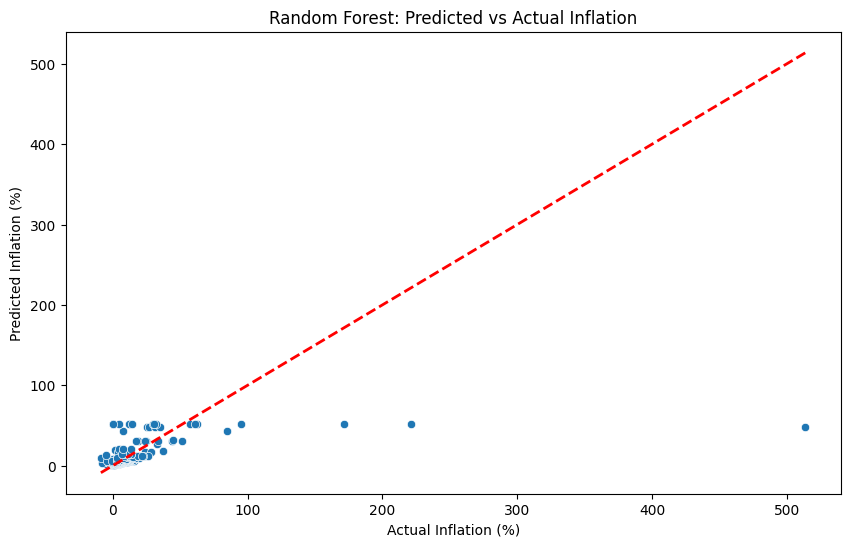

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(x="inflation_pct", y="prediction", data=pred_pdf)
plt.plot([pred_pdf.inflation_pct.min(), pred_pdf.inflation_pct.max()],
         [pred_pdf.inflation_pct.min(), pred_pdf.inflation_pct.max()],
         'r--', lw=2)  # line y=x
plt.xlabel("Actual Inflation (%)")
plt.ylabel("Predicted Inflation (%)")
plt.title("Random Forest: Predicted vs Actual Inflation")
plt.show()


/tmp/ipython-input-845867387.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=fi_df, palette="viridis")


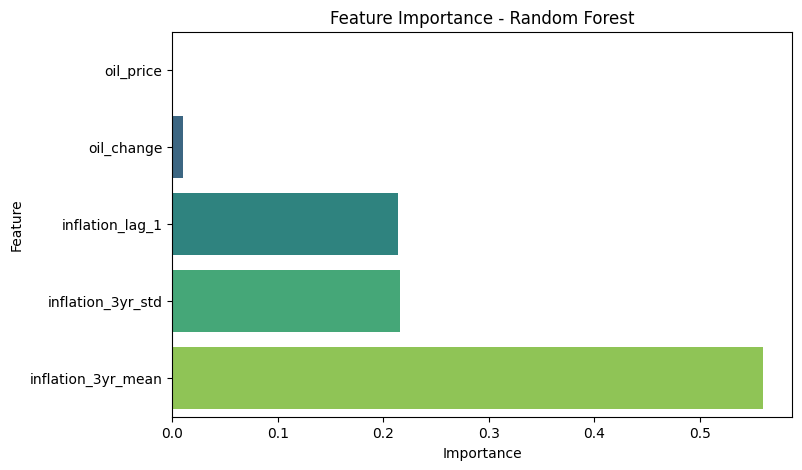

In [37]:
# Feature importance from model
fi = model.featureImportances.toArray() # Convert SparseVector to dense array
fi_df = pd.DataFrame({"feature": feature_cols, "importance": fi})
fi_df = fi_df.sort_values(by="importance", ascending=True)

plt.figure(figsize=(8,5))
sns.barplot(x="importance", y="feature", data=fi_df, palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

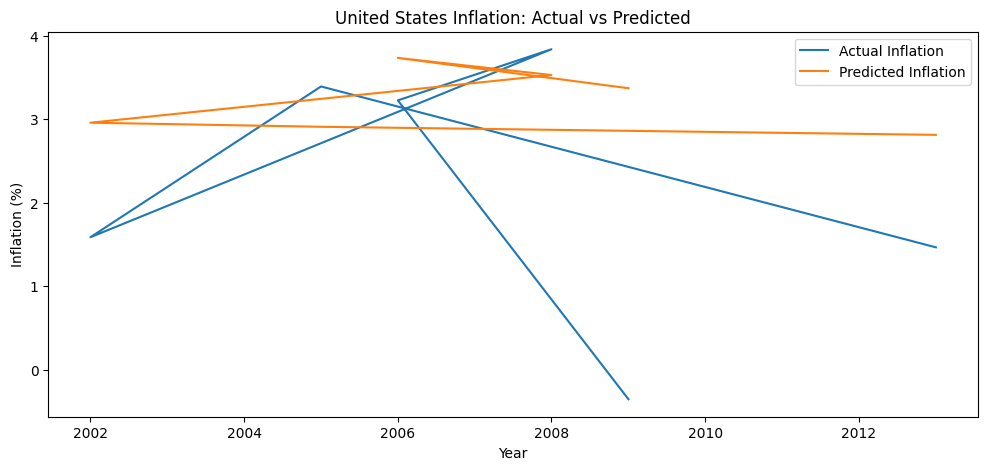

In [43]:
from pyspark.sql import functions as F

# 1️⃣ Assemble features vector but keep country_name & date
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
ml_df = assembler.transform(master_df).select("features", "inflation_pct", "country_name", "date")

# 2️⃣ Split into train/test
train_df, test_df = ml_df.randomSplit([0.8, 0.2], seed=42)

# 3️⃣ Train Random Forest
rf = RandomForestRegressor(featuresCol="features", labelCol="inflation_pct",
                           numTrees=100, maxDepth=5, seed=42)
model = rf.fit(train_df)

# 4️⃣ Make predictions (predictions will include country_name & date)
predictions = model.transform(test_df)

# 5️⃣ Convert to Pandas safely for plotting
pred_pdf_full = predictions.select("date", "country_name", "inflation_pct", "prediction").toPandas()

# 6️⃣ Example: Plot one country
import matplotlib.pyplot as plt

country_example = "United States"
subset = pred_pdf_full[pred_pdf_full.country_name == country_example]

plt.figure(figsize=(12,5))
plt.plot(subset.date, subset.inflation_pct, label="Actual Inflation")
plt.plot(subset.date, subset.prediction, label="Predicted Inflation")
plt.xlabel("Year")
plt.ylabel("Inflation (%)")
plt.title(f"{country_example} Inflation: Actual vs Predicted")
plt.legend()
plt.show()


In [44]:
# Save Pandas DataFrame to CSV for reproducibility
pred_pdf_full.to_csv("inflation_predictions.csv", index=False)


In [45]:
# Save trained Random Forest model
model.save("rf_inflation_model")
